## Imports

In [13]:
import os
import typing
from sklearn.gaussian_process.kernels import *
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler, FunctionTransformer
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import cm

DEBUG = True

# Set `EXTENDED_EVALUATION` to `True` in order to visualize your predictions.
EXTENDED_EVALUATION = False
EVALUATION_GRID_POINTS = 300  # Number of grid points used in extended evaluation

# Cost function constants
COST_W_UNDERPREDICT = 50.0
COST_W_NORMAL = 1.0

## Definitions

In [14]:
MODEL_CONFIG = {

    # score = 4.070 (hyperparameters derived from 100% of data)
    'kernel': 
        ConstantKernel(constant_value=1.078650707257617)
        * Matern(length_scale=0.20164570436472332, nu=1.5)
        + WhiteKernel(noise_level=0.005346546582467515),
        
    'alpha': 1e-10,
    'normalize_y': True,
    'n_restarts_optimizer': 4
}

In [15]:
class Model(object):
    """
    Model for this task.
    You need to implement the fit_model and predict methods
    without changing their signatures, but are allowed to create additional methods.
    """

    def __init__(self, normalize_x=True):
        """
        Initialize your model here.
        We already provide a random number generator for reproducibility.
        """
        self.rng = np.random.default_rng(seed=0)

        # TODO: Add custom initialization for your model here if necessary

        if normalize_x:
            self.transformer = StandardScaler()
        else:
            self.transformer = FunctionTransformer(func=None, inverse_func=None, validate=True)
        
        self.lamda = 0
        self.model = GaussianProcessRegressor(**MODEL_CONFIG)

    def make_predictions(self, test_x_2D: np.ndarray, test_x_AREA: np.ndarray) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Predict the pollution concentration for a given set of city_areas.
        :param test_x_2D: city_areas as a 2d NumPy float array of shape (NUM_SAMPLES, 2)
        :param test_x_AREA: city_area info for every sample in a form of a bool array (NUM_SAMPLES,)
        :return:
            Tuple of three 1d NumPy float arrays, each of shape (NUM_SAMPLES,),
            containing your predictions, the GP posterior mean, and the GP posterior stddev (in that order)
        """

        # TODO: Use your GP to estimate the posterior mean and stddev for each city_area here
        
        test_x = self.transformer.transform(test_x_2D)

        gp_means, gp_sigmas = self.model.predict(test_x, return_std=True)

        # TODO: Use the GP posterior to form your predictions here
        predictions = gp_means
        
        # Adjust predictions for residential areas
        mask = test_x_AREA
        predictions[mask] +=  self.lamda * gp_sigmas[mask]

        return predictions, gp_means, gp_sigmas
    
    def get_mean_variance(self, test_x_2D: np.ndarray) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]: 
        gp_means, gp_sigmas = self.model.predict(test_x_2D, return_std=True)
        return gp_means, gp_sigmas

    def fitting_model(self, train_y: np.ndarray, train_x_2D: np.ndarray, fit_lamda: bool = True):
        """
        Fit your model on the given training data.
        :param train_x_2D: Training features as a 2d NumPy float array of shape (NUM_SAMPLES, 2)
        :param train_y: Training pollution concentrations as a 1d NumPy float array of shape (NUM_SAMPLES,)
        """

        # TODO: Fit your model here

        self.transformer = self.transformer.fit(train_x_2D)
        train_x = self.transformer.transform(train_x_2D)

        self.model = self.model.fit(train_x, train_y)
        
        if fit_lamda:
            means, sigmas = self.get_mean_variance(train_x)
            initial_lambda = 1
            self.lamda = minimize(lambda_cost_function, initial_lambda, args=(means, sigmas, train_y)).x[0]
        return

In [16]:
# You don't have to change this function
def cost_function(ground_truth: np.ndarray, predictions: np.ndarray, AREA_idxs: np.ndarray) -> float:
    """
    Calculates the cost of a set of predictions.

    :param ground_truth: Ground truth pollution levels as a 1d NumPy float array
    :param predictions: Predicted pollution levels as a 1d NumPy float array
    :param AREA_idxs: city_area info for every sample in a form of a bool array (NUM_SAMPLES,)
    :return: Total cost of all predictions as a single float
    """
    assert ground_truth.ndim == 1 and predictions.ndim == 1 and ground_truth.shape == predictions.shape

    # Unweighted cost
    cost = (ground_truth - predictions) ** 2
    weights = np.ones_like(cost) * COST_W_NORMAL

    # Case i): underprediction
    mask = (predictions < ground_truth) & [bool(AREA_idx) for AREA_idx in AREA_idxs]
    weights[mask] = COST_W_UNDERPREDICT

    # Weigh the cost and return the average
    return np.mean(cost * weights)


In [17]:
def lambda_cost_function(lambda_val, mu_values, sigma_values, y_true_values):
    """
    Calculates the cost of predictions for a given lambda value.

    :param lambda_val: Value of lambda to compute predictions
    :param mu_values: Predicted mean values (mu)
    :param sigma_values: Predicted standard deviation values (sigma)
    :param y_true_values: Ground truth values
    :return: Total cost for the given lambda value
    """
    
    # Compute predictions for the given lambda value
    predictions = mu_values + lambda_val * sigma_values
    
    # Use the provided cost function to compute the cost
    cost = cost_function(y_true_values, predictions, np.ones_like(y_true_values, dtype=bool))
    
    return cost

In [18]:
# You don't have to change this function
def is_in_circle(coor, circle_coor):
    """
    Checks if a coordinate is inside a circle.
    :param coor: 2D coordinate
    :param circle_coor: 3D coordinate of the circle center and its radius
    :return: True if the coordinate is inside the circle, False otherwise
    """
    return (coor[0] - circle_coor[0])**2 + (coor[1] - circle_coor[1])**2 < circle_coor[2]**2

In [19]:
# You don't have to change this function
def determine_city_area_idx(visualization_xs_2D):
    """
    Determines the city_area index for each coordinate in the visualization grid.
    :param visualization_xs_2D: 2D coordinates of the visualization grid
    :return: 1D array of city_area indexes
    """
    # Circles coordinates
    circles = np.array([[0.5488135, 0.71518937, 0.17167342],
                    [0.79915856, 0.46147936, 0.1567626 ],
                    [0.26455561, 0.77423369, 0.10298338],
                    [0.6976312,  0.06022547, 0.04015634],
                    [0.31542835, 0.36371077, 0.17985623],
                    [0.15896958, 0.11037514, 0.07244247],
                    [0.82099323, 0.09710128, 0.08136552],
                    [0.41426299, 0.0641475,  0.04442035],
                    [0.09394051, 0.5759465,  0.08729856],
                    [0.84640867, 0.69947928, 0.04568374],
                    [0.23789282, 0.934214,   0.04039037],
                    [0.82076712, 0.90884372, 0.07434012],
                    [0.09961493, 0.94530153, 0.04755969],
                    [0.88172021, 0.2724369,  0.04483477],
                    [0.9425836,  0.6339977,  0.04979664]])

    visualization_xs_AREA = np.zeros((visualization_xs_2D.shape[0],))

    for i,coor in enumerate(visualization_xs_2D):
        visualization_xs_AREA[i] = any([is_in_circle(coor, circ) for circ in circles])

    return visualization_xs_AREA

In [20]:
# You don't have to change this function
def perform_extended_evaluation(model: Model, output_dir: str = '/results'):
    """
    Visualizes the predictions of a fitted model.
    :param model: Fitted model to be visualized
    :param output_dir: Directory in which the visualizations will be stored
    """
    print('Performing extended evaluation')

    # Visualize on a uniform grid over the entire coordinate system
    grid_lat, grid_lon = np.meshgrid(
        np.linspace(0, EVALUATION_GRID_POINTS - 1, num=EVALUATION_GRID_POINTS) / EVALUATION_GRID_POINTS,
        np.linspace(0, EVALUATION_GRID_POINTS - 1, num=EVALUATION_GRID_POINTS) / EVALUATION_GRID_POINTS,
    )
    visualization_xs_2D = np.stack((grid_lon.flatten(), grid_lat.flatten()), axis=1)
    visualization_xs_AREA = determine_city_area_idx(visualization_xs_2D)

    # Obtain predictions, means, and stddevs over the entire map
    predictions, gp_mean, gp_stddev = model.make_predictions(visualization_xs_2D, visualization_xs_AREA)
    predictions = np.reshape(predictions, (EVALUATION_GRID_POINTS, EVALUATION_GRID_POINTS))
    gp_mean = np.reshape(gp_mean, (EVALUATION_GRID_POINTS, EVALUATION_GRID_POINTS))

    vmin, vmax = 0.0, 65.0

    # Plot the actual predictions
    fig, ax = plt.subplots()
    ax.set_title('Extended visualization of task 1')
    im = ax.imshow(predictions, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(im, ax = ax)

    # Save figure to pdf
    figure_path = os.path.join(output_dir, 'extended_evaluation.pdf')
    fig.savefig(figure_path)
    print(f'Saved extended evaluation to {figure_path}')

    plt.show()

In [21]:
def extract_city_area_information(train_x: np.ndarray, test_x: np.ndarray) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Extracts the city_area information from the training and test features.
    :param train_x: Training features
    :param test_x: Test features
    :return: Tuple of (training features' 2D coordinates, training features' city_area information,
        test features' 2D coordinates, test features' city_area information)
    """

    #TODO: Extract the city_area information from the training and test features
    train_x_2D = np.array(train_x[:, :2], dtype=float)
    train_x_AREA = np.array(train_x[:, 2], dtype=bool)
    test_x_2D = np.array(test_x[:, :2], dtype=float)
    test_x_AREA = np.array(test_x[:, 2], dtype=bool)

    assert train_x_2D.shape[0] == train_x_AREA.shape[0] and test_x_2D.shape[0] == test_x_AREA.shape[0]
    assert train_x_2D.shape[1] == 2 and test_x_2D.shape[1] == 2
    assert train_x_AREA.ndim == 1 and test_x_AREA.ndim == 1

    return train_x_2D, train_x_AREA, test_x_2D, test_x_AREA

## Load Data

In [22]:
train_x = np.loadtxt('../train_x.csv', delimiter=',', skiprows=1)
train_y = np.loadtxt('../train_y.csv', delimiter=',', skiprows=1)
test_x = np.loadtxt('../test_x.csv', delimiter=',', skiprows=1)

train_x_2D, train_x_AREA, test_x_2D, test_x_AREA = extract_city_area_information(train_x, test_x)

if DEBUG:
    print(f"Shape of train_x_2D: {train_x_2D.shape}")
    print(f"Shape of train_x_AREA: {train_x_AREA.shape}")
    print(f"Shape of test_x_2D: {test_x_2D.shape}")
    print(f"Shape of test_x_AREA: {test_x_AREA.shape}")

Shape of train_x_2D: (15189, 2)
Shape of train_x_AREA: (15189,)
Shape of test_x_2D: (3311, 2)
Shape of test_x_AREA: (3311,)


### Train-Val Split

In [23]:
train_x_2D_train, train_x_2D_val, train_x_AREA_train, train_x_AREA_val, train_y_train, train_y_val = train_test_split(
    train_x_2D, train_x_AREA, train_y, test_size=0.3, random_state=6
)

if DEBUG:
    print(f"Shape of train_x_2D_train: {train_x_2D_train.shape}")
    print(f"Shape of train_x_AREA_train: {train_x_AREA_train.shape}")
    print(f"Shape of train_y_train: {train_y_train.shape}")
    print(f"Shape of train_x_2D_val: {train_x_2D_val.shape}")
    print(f"Shape of train_x_AREA_val: {train_x_AREA_val.shape}")
    print(f"Shape of train_y_val: {train_y_val.shape}")


Shape of train_x_2D_train: (10632, 2)
Shape of train_x_AREA_train: (10632,)
Shape of train_y_train: (10632,)
Shape of train_x_2D_val: (4557, 2)
Shape of train_x_AREA_val: (4557,)
Shape of train_y_val: (4557,)


## Fit

In [24]:
model = Model(normalize_x=True)
model.fitting_model(train_y_train, train_x_2D_train, fit_lamda=True)

## Model Inspection

In [25]:
model.model.kernel_

1.02**2 * Matern(length_scale=0.195, nu=1.5) + WhiteKernel(noise_level=0.00543)

In [26]:
model.model.kernel_.get_params()

{'k1': 1.02**2 * Matern(length_scale=0.195, nu=1.5),
 'k2': WhiteKernel(noise_level=0.00543),
 'k1__k1': 1.02**2,
 'k1__k2': Matern(length_scale=0.195, nu=1.5),
 'k1__k1__constant_value': 1.0347682221487602,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2__length_scale': 0.19477170652781176,
 'k1__k2__length_scale_bounds': (1e-05, 100000.0),
 'k1__k2__nu': 1.5,
 'k2__noise_level': 0.005428582102921252,
 'k2__noise_level_bounds': (1e-05, 100000.0)}

In [27]:
# Ignore if kernel parameters are fixed
kernel_log_lilelihood = model.model.log_marginal_likelihood()
kernel_prob = np.exp(kernel_log_lilelihood)

print(f"Kernel Log-Likelihood\t{kernel_log_lilelihood:.2f}.")
print(f"Probability\t\t{kernel_prob:.2e}.")

Kernel Log-Likelihood	5762.82.
Probability		inf.


/var/folders/1q/0g9rg9bs7c9ctytl25m9jpx00000gn/T/ipykernel_92946/2650742437.py:3: RuntimeWarning: overflow encountered in exp
  kernel_prob = np.exp(kernel_log_lilelihood)


##  R2 Score

In [28]:
train_score = model.model.score(model.transformer.transform(train_x_2D_train), train_y_train)
val_score = model.model.score(model.transformer.transform(train_x_2D_val), train_y_val)

print(f"R^2 score for the training set: {train_score:.4f}")
print(f"R^2 score for the validation set: {val_score:.4f}")

R^2 score for the training set: 0.9970
R^2 score for the validation set: 0.9903


## Cost Function

### With bias in residential areas

In [29]:
print(f"Optimal lamda = {model.lamda:.3f}")

Optimal lamda = 0.979


In [30]:
train_predictions = model.make_predictions(train_x_2D_train, train_x_AREA_train)
val_predictions = model.make_predictions(train_x_2D_val, train_x_AREA_val)
test_predictions = model.make_predictions(test_x_2D, test_x_AREA)

In [31]:
train_cost = cost_function(train_y_train, train_predictions[0], train_x_AREA_train)
val_cost = cost_function(train_y_val, val_predictions[0], train_x_AREA_val)

print(f"Cost for the training set: {train_cost:.4f}")
print(f"Cost for the validation set: {val_cost:.4f}")

Cost for the training set: 2.9493
Cost for the validation set: 10.3629


### Without bias in residential areas (lamda = 0)

In [32]:
opt_lamda, model.lamda = model.lamda, 0
train_predictions = model.make_predictions(train_x_2D_train, train_x_AREA_train)
val_predictions = model.make_predictions(train_x_2D_val, train_x_AREA_val)
test_predictions = model.make_predictions(test_x_2D, test_x_AREA)
model.lamda = opt_lamda

In [33]:
train_cost = cost_function(train_y_train, train_predictions[0], train_x_AREA_train)
val_cost = cost_function(train_y_val, val_predictions[0], train_x_AREA_val)

print(f"Cost for the training set: {train_cost:.4f}")
print(f"Cost for the validation set: {val_cost:.4f}")

Cost for the training set: 12.7142
Cost for the validation set: 37.7447


### With lamda = 1 (baseline)

In [34]:
opt_lamda, model.lamda = model.lamda, 1
train_predictions = model.make_predictions(train_x_2D_train, train_x_AREA_train)
val_predictions = model.make_predictions(train_x_2D_val, train_x_AREA_val)
test_predictions = model.make_predictions(test_x_2D, test_x_AREA)
model.lamda = opt_lamda

In [35]:
train_cost = cost_function(train_y_train, train_predictions[0], train_x_AREA_train)
val_cost = cost_function(train_y_val, val_predictions[0], train_x_AREA_val)

print(f"Cost for the training set: {train_cost:.4f}")
print(f"Cost for the validation set: {val_cost:.4f}")

Cost for the training set: 2.9521
Cost for the validation set: 10.2112


## Predictions Distribution

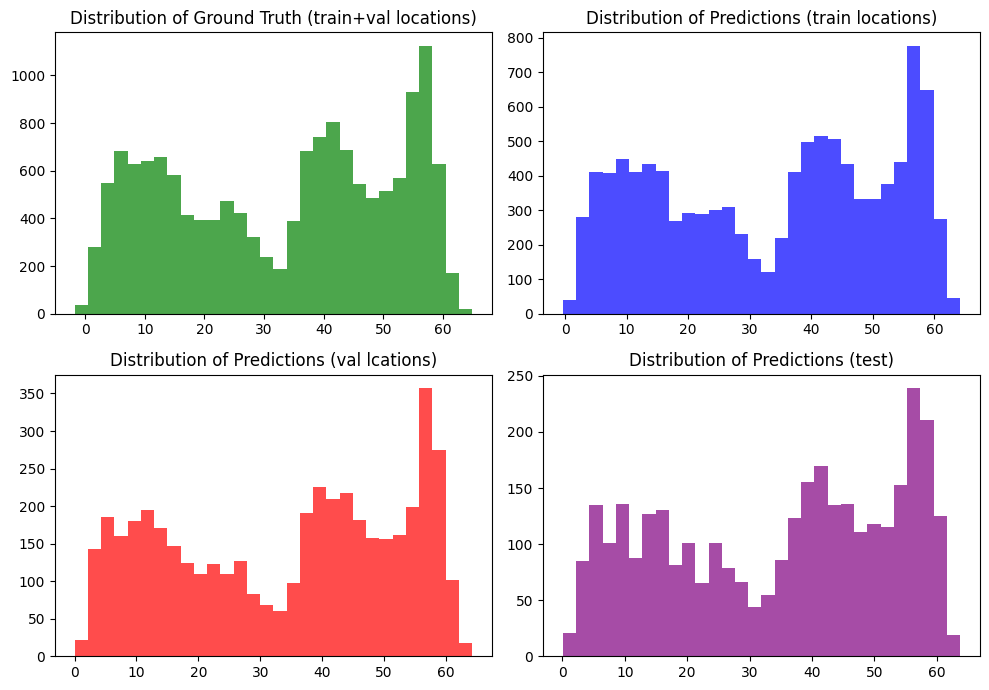

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7))

axs[0, 0].hist(train_y, bins=30, color='green', alpha=0.7)
axs[0, 0].set_title('Distribution of Ground Truth (train+val locations)')

axs[0, 1].hist(train_predictions[0], bins=30, color='blue', alpha=0.7)
axs[0, 1].set_title('Distribution of Predictions (train locations)')

axs[1, 0].hist(val_predictions[0], bins=30, color='red', alpha=0.7)
axs[1, 0].set_title('Distribution of Predictions (val lcations)')

axs[1, 1].hist(test_predictions[0], bins=30, color='purple', alpha=0.7)
axs[1, 1].set_title('Distribution of Predictions (test)')

plt.tight_layout()
plt.show()


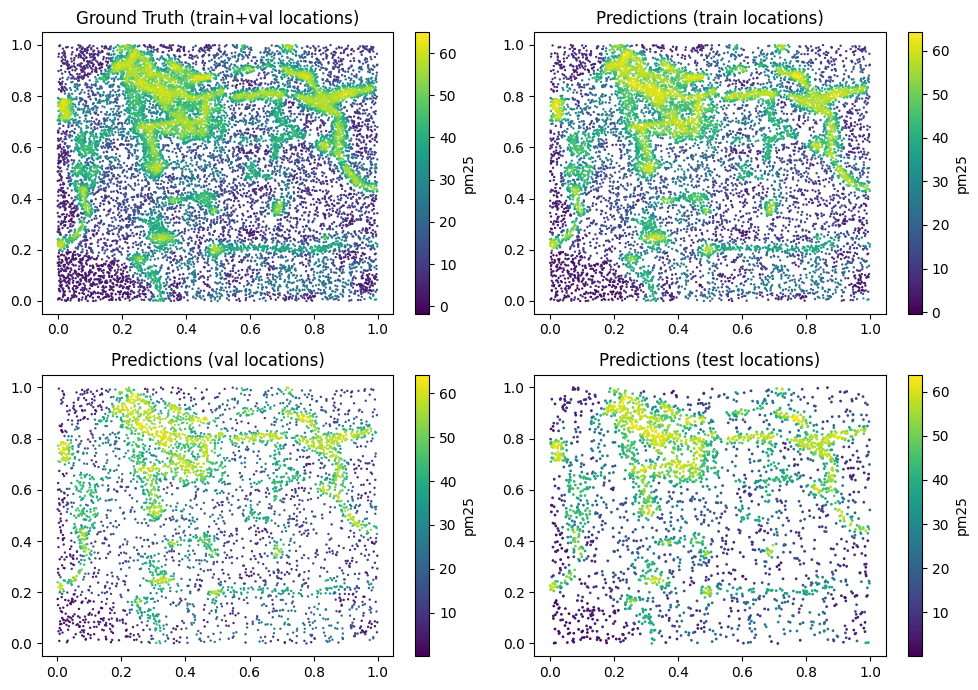

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7))

sc = axs[0, 0].scatter(*train_x_2D.T, c=train_y, s=0.5)
axs[0, 0].set_title('Ground Truth (train+val locations)')
fig.colorbar(sc, ax=axs[0, 0], label='pm25')

sc = axs[0, 1].scatter(*train_x_2D_train.T, c=train_predictions[0], s=0.5)
axs[0, 1].set_title('Predictions (train locations)')
fig.colorbar(sc, ax=axs[0, 1], label='pm25')

sc = axs[1, 0].scatter(*train_x_2D_val.T, c=val_predictions[0], s=0.5)
axs[1, 0].set_title('Predictions (val locations)')
fig.colorbar(sc, ax=axs[1, 0], label='pm25')

sc = axs[1, 1].scatter(*test_x_2D.T, c=test_predictions[0], s=1)
axs[1, 1].set_title('Predictions (test locations)')
fig.colorbar(sc, ax=axs[1, 1], label='pm25')

plt.tight_layout()
plt.show()


In [38]:
if EXTENDED_EVALUATION:
    perform_extended_evaluation(model, output_dir='.')

## Location Distribution

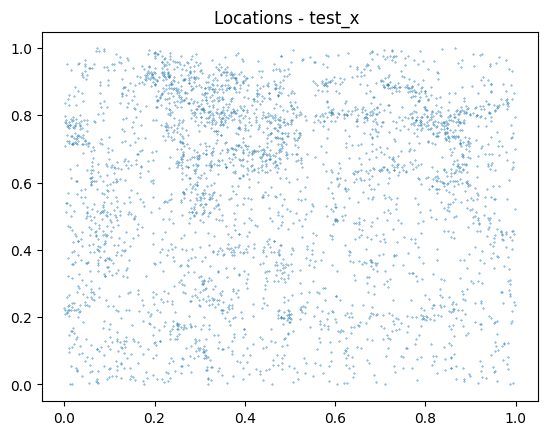

In [39]:
plt.scatter(*test_x_2D.T, s=0.1)
plt.title('Locations - test_x ')
plt.show()

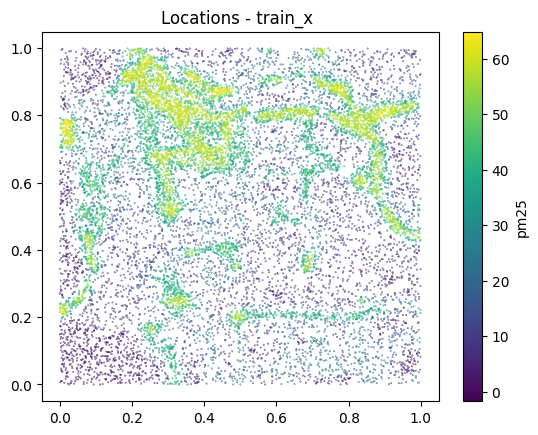

In [40]:
plt.scatter(*train_x_2D.T, c=train_y, s=0.1)
plt.title('Locations - train_x ')
plt.colorbar(label='pm25')
plt.show()

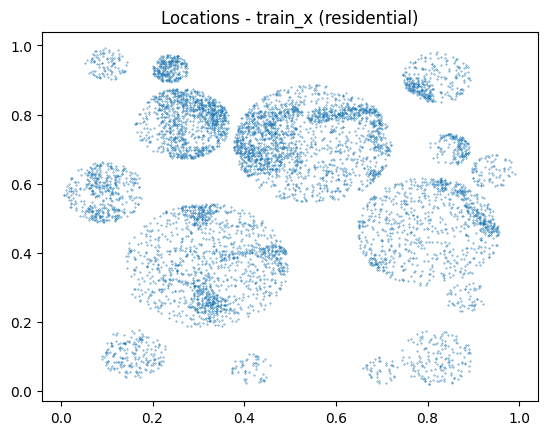

In [41]:
plt.scatter(*train_x_2D[train_x_AREA].T,  s=0.1)
plt.title('Locations - train_x (residential)')
plt.show()

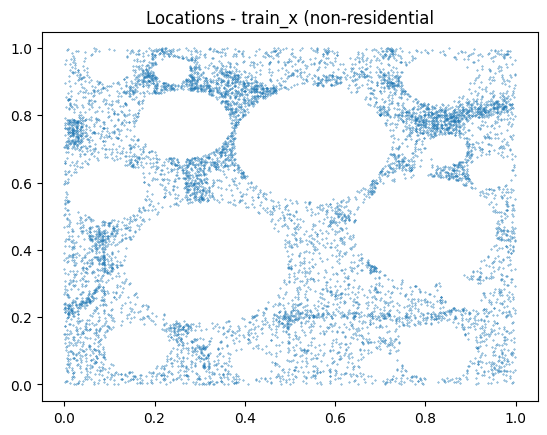

In [42]:
plt.scatter(*train_x_2D[~train_x_AREA].T, s=0.1)
plt.title('Locations - train_x (non-residential')
plt.show()